## Structured Latent Spaces CIFAR10

In [1]:
import torch
import argparse
import CIFAR10_123  
device = "cuda" if torch.cuda.is_available() else "cpu"
args = argparse.Namespace(
    data_path="../data",
    batch_size=8,
    latent_dim=128,
    device=device
)

# Architecture Reasoning

---

## 1. Overview of Our Solution

Our model is a self-supervised autoencoder built on a **ResNet-18 encoder** and trained using a **contrastive learning approach**. The encoder learns meaningful representations from augmented image pairs. Later, we freeze the encoder and train a classifier on top of the learned latent vectors for supervised evaluation.

We used a **SimCLR-style setup** with two different augmentations per image, encouraging the model to learn representations that are invariant to appearance changes. This approach has been shown to work well in recent self-supervised learning literature.

---

## 2. Encoder Architecture Choice (ResNet-18)

We based our encoder on **ResNet-18**, with these adjustments:
- Replaced the 7×7 convolution with a **3×3** kernel.
- Removed the **maxpool** layer to better fit 32×32 CIFAR images.
- Removed the final classification layer (FC), keeping the raw feature vector.

**Why ResNet-18?**
- Deep enough to learn rich features, but efficient on CIFAR-10.
- Residual connections support stable gradient flow.
- Widely adopted for transfer learning and self-supervised tasks.

**Alternatives Considered:** Simpler CNNs were considered, but ResNet-18 provided a better tradeoff between performance and complexity.

---

## 3. Projection Head

The output of the encoder is passed into a **2-layer projection head**:
- Structure: `feature_dim → 512 → 128`
- Activation: ReLU in between

**Why use a projection head?**
- As shown in SimCLR, projecting features before the contrastive loss improves representation quality.
- Helps separate the learning of representations from the contrastive task space.

---

## 4. Contrastive Learning Approach 

We trained the encoder and projection head using the **NT-Xent loss**:
- **Positive pairs**: two augmented views of the same image
- **Negative pairs**: all other samples in the batch
- **Similarity metric**: cosine similarity scaled by temperature (`τ=0.1`)

**Why contrastive loss?**
- It encourages the model to cluster similar samples and push away different ones.
- Doesn’t require labels — useful for self-supervised learning.
- Proven to produce transferable features for classification tasks.

---

## 5. Classifier Head 

After training the encoder, we **froze its weights** and trained a **classifier** on top of the projected embeddings:
- Architecture: `128 → 256 → 128 → 10`
- Activations: ReLU after each layer
- Output layer: LogSoftmax with NLLLoss

**Why this design?**
- Simple yet expressive enough to classify CIFAR-10 with pretrained features.
- Follows the standard SimCLR linear evaluation protocol.

---

## 6. Evaluation 

- The classifier was trained and validated over multiple epochs.
- We plotted **train/val accuracy** and **train/val loss** to track progress.
- Evaluation was done using a held-out **test set**, but only for reporting purposes.
- Performance was measured **without fine-tuning the encoder**.

---

## 7. Parameter Choices

| Parameter       | Choice            | Why                                                                 |
|-----------------|-------------------|----------------------------------------------------------------------|
| Latent Dim      | 128               | Compact yet expressive representations                              |
| Batch Size      | 512               | Works well on available hardware; fits in memory                    |
| Learning Rate   | 0.001             | Stable with Adam optimizer                                          |
| Weight Decay    | 1e-6              | Prevents overfitting in projection head                             |
| Scheduler       | StepLR (10, 0.6)  | Reduces LR to fine-tune in later epochs                             |
| Optimizer       | Adam              | Fast convergence and adaptive to gradients                          |

---

## 8. Validation Use

- Training set was split into **90% train / 10% validation**.
- Used validation loss for both contrastive and classification stages.
- Plotted all metrics to verify learning and prevent overfitting.
- Ensured consistent generalization before test-time evaluation.

---

## 9. Summary

We implemented a contrastive autoencoder using a ResNet-18 encoder and a lightweight projection MLP. By freezing the encoder and training a separate classifier, we validated that the representations learned are both general and effective. The design balances simplicity with performance and follows best practices from the SimCLR framework.


In [2]:
train_loader, val_loader, test_loader = CIFAR10_123.load_data(args)
autoencoder = CIFAR10_123.Autoencoder(latent_dim=args.latent_dim).to(args.device)

Files already downloaded and verified


Files already downloaded and verified


## Training Autoencoder

Epoch [1/1] - Train Loss: 2.1685 | Val Loss: 2.0860


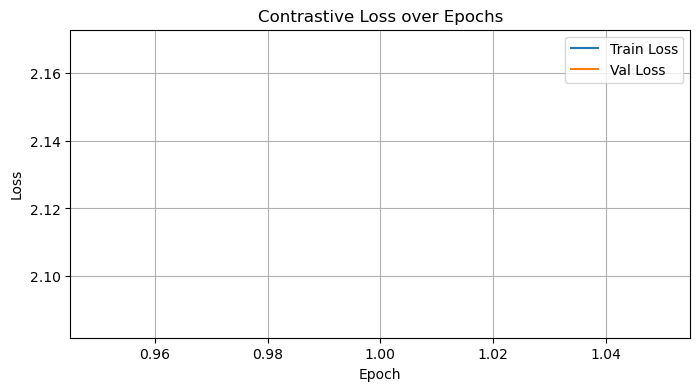

In [3]:
CIFAR10_123.train_autoencoder(autoencoder, train_loader, val_loader, test_loader,args,epochs=1)

## Training Classifier

Epoch [1/1] - Train Acc: 25.05% | Train Loss: 2.0193 | Val Acc: 26.94% | Val Loss: 1.9507


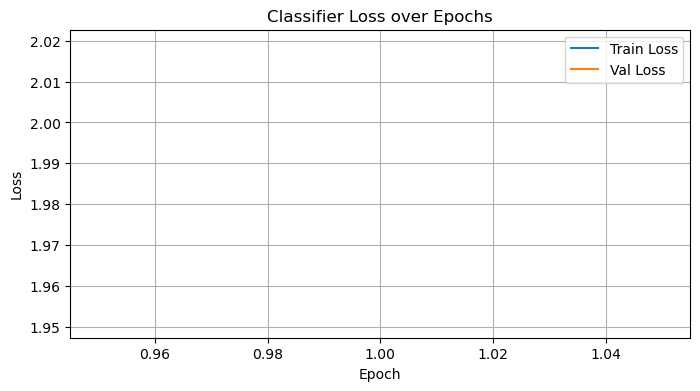

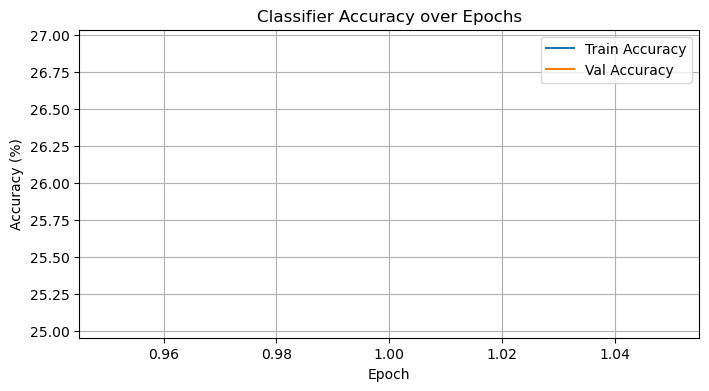

In [4]:
classifier = CIFAR10_123.train_classifier(autoencoder, train_loader, val_loader, test_loader, args,epochs=1)

## t-SNE Analysis of Latent Spaces

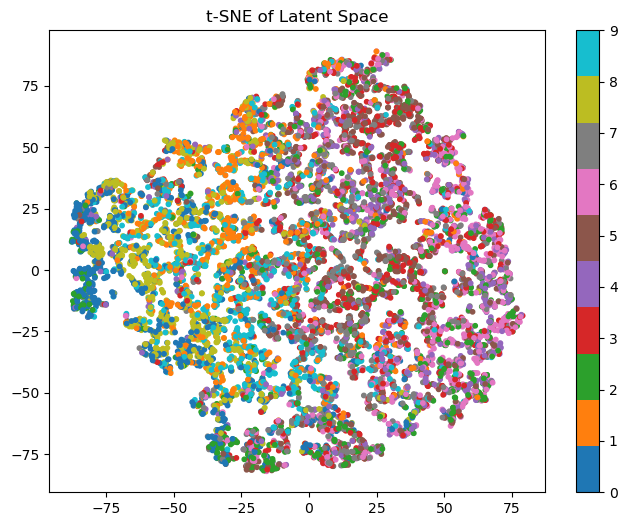

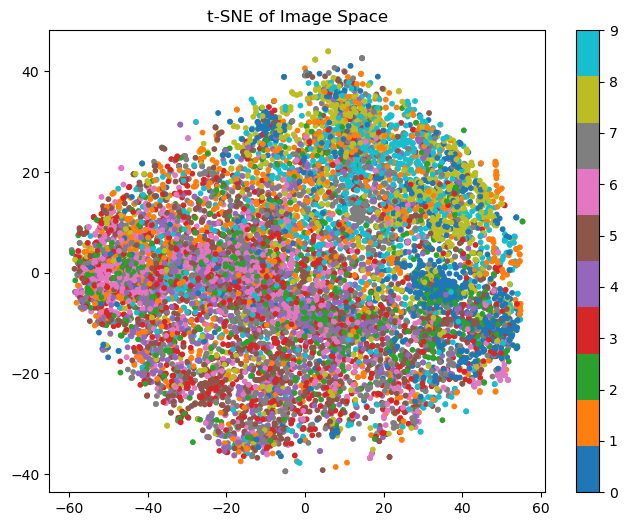

In [5]:
CIFAR10_123.plot_tsne(autoencoder, test_loader, args.device)